# Multi-Omics Analysis for SKCM Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os
import datetime
import random
import functools
import typing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
#sns.set_theme(style="darkgrid")
sns.set_theme(palette="colorblind", font_scale=1.5)
import lifelines
from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

In [2]:
import coxae
from coxae.model import CoxAutoencoderClustering
from coxae.utils import get_kmfs
from coxae.preprocessing import dict_of_dfs_to_df_list, merge_df_list, merge_dict_of_dfs, stack_dicts


In [3]:
# Set the random seeds
seed = 0
np.random.seed(seed)
random.seed(seed)

In [4]:
def plot_dim_reduction(
        df_or_dfs:typing.Union[dict, pd.DataFrame],
        df_clin:pd.DataFrame,
        dim_reduction = TSNE,
        dim_reduction_label = "TSNE_{}",
        ):
    n_components = 2
    df_features = (
        merge_df_list(dict_of_dfs_to_df_list(df_or_dfs))
        if isinstance(df_or_dfs, dict) else
        df_or_dfs
    )
    df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(df_features.values), index=df_features.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
    df_plot = df_plot.join(df_clin)
    sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="observed")
    plt.show()
    sns.scatterplot(data=df_plot[df_plot["observed"]==1], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
    plt.show()
    df_plot

## Data Acquisition and Pre-Processing

### Acquiring data from the MAUI's paper study

In [5]:
data_directory = "./data/hierae_data/processed/SKCM/merged"

In [6]:
data = pd.read_csv(os.path.join(data_directory, 'new_clinical_multi_omics_with_rppa.csv'))

In [7]:
data.shape

(238, 85256)

In [8]:
data_no_na = data.dropna(axis="columns")
data_no_na.shape

(238, 85256)

In [9]:
survival = data[["OS","OS.time"]].rename(columns={"OS":"observed","OS.time":"duration"})
survival.head()

,observed,duration
0,0,486
1,0,2950
2,0,439
3,1,1154
4,0,210


See which omics layers are available in the dataset

In [10]:
set(col.split("_")[0] for col in data.columns)

{'OS',
 'OS.time',
 'clinical',
 'cnv',
 'gex',
 'meth',
 'mirna',
 'mutation',
 'rppa'}

Plot a Kaplan-Meier plot of the whole dataset to have better view of it

<AxesSubplot:xlabel='timeline'>

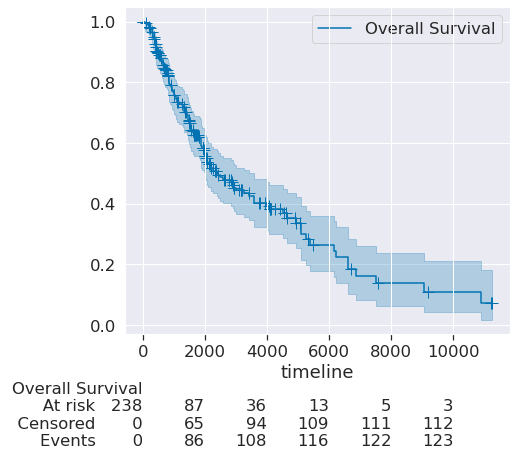

In [11]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=survival["duration"],
        event_observed=survival["observed"])
plt.figure(figsize=(7.5,7))
kmf.plot(show_censors=1, ci_show=1, at_risk_counts=True,)# loc=slice(0,356*6))

Check the maximum RNAseq count value in the dataset.

Get the datasets that will be used as features:

In [12]:
df_clin = survival
df_clinical_features = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="clinical"]]
df_cnv = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="cnv"]]
df_gex = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="gex"]].apply(lambda x: np.log2(np.where(x<0,np.zeros_like(x),x)+1)) # Max between the value and x is taken due to some gene expression values being less than one for some reason
df_meth = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="meth"]]
df_mirna = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="mirna"]].apply(lambda x: np.log2(np.where(x<0,np.zeros_like(x),x)+1))
df_mutation = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="mutation"]]
df_rppa = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="rppa"]]

feature_dfs = {
    "clin": df_clinical_features,
    "cnv": df_cnv,
    "gex": df_gex,
    "meth": df_meth,
    "mirna": df_mirna,
    "mut": df_mutation,
    "rppa": df_rppa
}

Get the input dataset:

In [13]:
X = {k:feature_dfs[k].values for k in feature_dfs}
durations = df_clin["duration"].values
events = df_clin["observed"].values

Plot a reduced dimensionality view of the dataset:

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


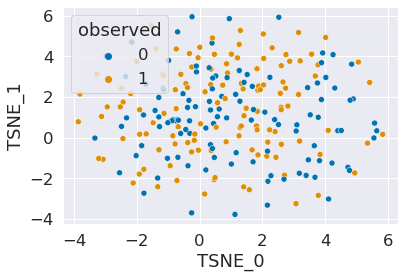

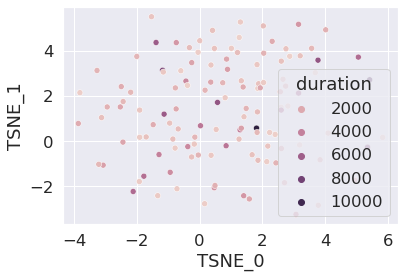

In [14]:
plot_dim_reduction(merge_dict_of_dfs(feature_dfs), df_clin)

## Use the model to analyse the data

In [15]:
model = CoxAutoencoderClustering(encoding_feature_selector=coxae.feature_selection.CoxPHFeatureSelector(limit_significant=20, get_most_significant_combination_time_limit=0))
model.fit({k:X[k] for k in X}, durations, events)

In [16]:
clusters = model.cluster(X)
hazards = model.hazard(X)
_, p_value = model.logrank_p_score(clusters, durations, events)
c_index = model.concordance_index(hazards, durations, events)
p_value, c_index

(1.5173506772573245e-63, 0.9907854600915099)

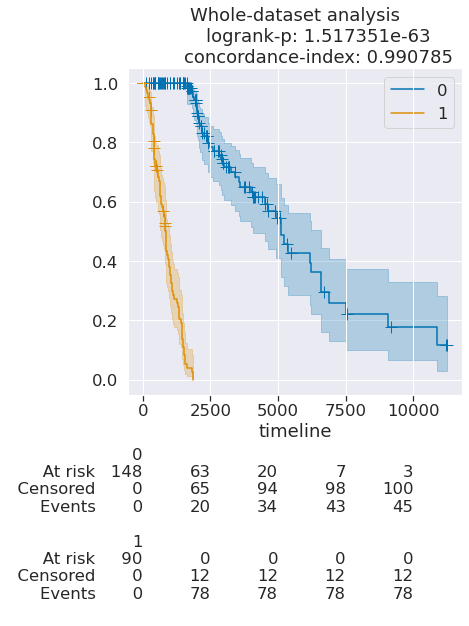

In [17]:
plt.figure(figsize=(6,6))
if not np.isnan(p_value):
    ax = plt.gca()
    kmfs, _ = get_kmfs(clusters, durations, events)
    for kmf in kmfs:
        kmf.plot(show_censors=1, ci_show=1, ax=ax)
    lifelines.plotting.add_at_risk_counts(*kmfs, ax=ax)
    plt.title(
        """Whole-dataset analysis
        logrank-p: {p_value:.6e}
        concordance-index: {c_index:.6f}""".format(
            p_value=p_value,
            c_index=c_index,
        )
    )
    for fmt in ["png", "pdf"]:
        plt.savefig("whole-dset-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(),fmt=fmt), bbox_inches="tight")


In [18]:
topk_feature_idxs = {
    layer: np.argsort(model.input_feature_selectors[layer].selector.scores_)[:model.input_feature_selectors[layer].selector.k]
    for layer in model.input_feature_selectors
}
topk_feature_dfs = {
    layer: feature_dfs[layer].iloc[:,topk_feature_idxs[layer]]
    for layer in feature_dfs
}
df_ae_input = merge_dict_of_dfs(topk_feature_dfs)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


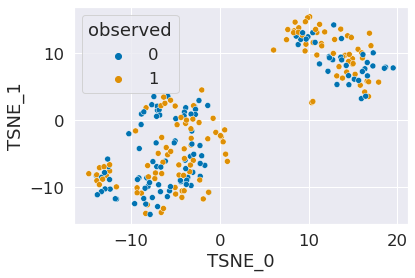

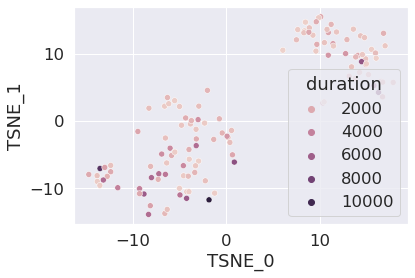

In [19]:
plot_dim_reduction(df_ae_input, df_clin)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


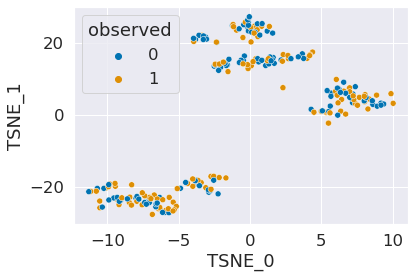

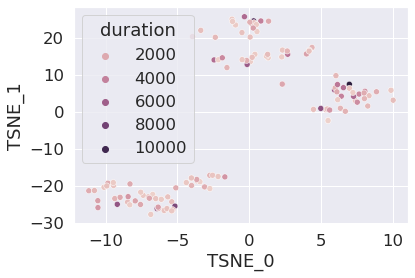

In [20]:
plot_dim_reduction(pd.DataFrame(model._CoxAutoencoderClustering__integrate(df_ae_input.values)), df_clin)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


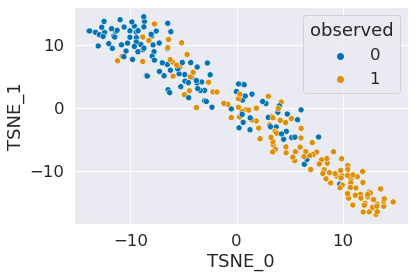

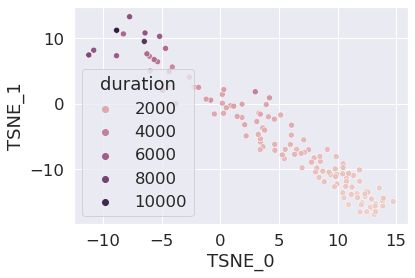

In [21]:
plot_dim_reduction(pd.DataFrame(model.integrate(X)), df_clin)

In [22]:
for df, name in zip([merge_dict_of_dfs(feature_dfs),df_ae_input.copy()],["all","ae_input"]):
    df["clusters"] = clusters
    df.to_csv("{model}_{name}.csv".format(model=type(model).__name__, name=name))

In [23]:
feature_importance_matrix = model.ae.get_feature_importance_matrix()[:,model.encoding_feature_selector.significant_indexes]
n_features = df_ae_input.shape[1]
n_features_to_get = 1
feature_importance_ordering = np.argsort(np.abs(feature_importance_matrix), axis=0)
most_important_features_ordering = feature_importance_ordering[-n_features_to_get:,:]
most_important_features = set(most_important_features_ordering.reshape(-1))
df_ae_important = df_ae_input.iloc[:,list(most_important_features)]

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


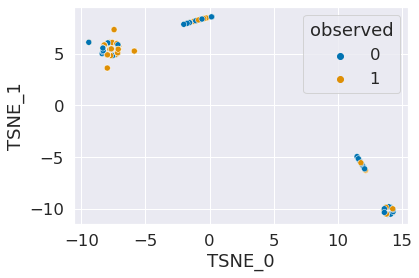

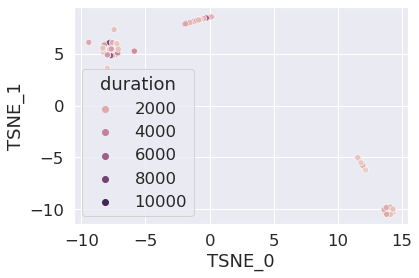

In [24]:
plot_dim_reduction(df_ae_important, df_clin)

In [25]:
df_ae_important.describe()

,clinical_gender_FEMALE,mirna_hsa-miR-552-5p
count,238.000000,238.000000
mean,0.394958,0.142068
std,0.489872,0.283766
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.202413
max,1.000000,1.354851


In [26]:
len(df_ae_important.columns.tolist()), df_ae_important.columns.tolist()

(2, ['clinical_gender_FEMALE', 'mirna_hsa-miR-552-5p'])

In [27]:
n_runs = 32
results = []
selected_feature_sets = []
significant_feature_sets = []
sets_absolute_neural_path_weights = []
significant_feature_indexes = []
for i in range(n_runs):
    model = CoxAutoencoderClustering(encoding_feature_selector=coxae.feature_selection.CoxPHFeatureSelector(limit_significant=20, get_most_significant_combination_time_limit=0))
    model.fit({k:X[k] for k in X}, durations, events)
    
    clusters = model.cluster(X)
    hazards = model.hazard(X)
    _, p_value = model.logrank_p_score(clusters, durations, events)
    c_index = model.concordance_index(hazards, durations, events)

    plt.figure(figsize=(6,6))
    if not np.isnan(p_value):
        ax = plt.gca()
        kmfs, _ = get_kmfs(clusters, durations, events)
        for kmf in kmfs:
            kmf.plot(show_censors=1, ci_show=1, ax=ax)
        lifelines.plotting.add_at_risk_counts(*kmfs, ax=ax)
        plt.title(
            """Whole-dataset analysis
            logrank-p: {p_value:.6e}
            concordance-index: {c_index:.6f}""".format(
                p_value=p_value,
                c_index=c_index,
            )
        )
        for fmt in ["png", "pdf"]:
            plt.savefig("repetition-dset-{model}-{date}-{rep}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(),fmt=fmt, rep=i), bbox_inches="tight")
        plt.close()

    topk_feature_idxs = {
        layer: np.argsort(model.input_feature_selectors[layer].selector.scores_)[:model.input_feature_selectors[layer].selector.k]
        for layer in model.input_feature_selectors
    }
    topk_feature_scores = {
        layer: model.input_feature_selectors[layer].selector.scores_[np.argsort(model.input_feature_selectors[layer].selector.scores_)[:model.input_feature_selectors[layer].selector.k]]
        for layer in model.input_feature_selectors
    }
    topk_feature_dfs = {
        layer: feature_dfs[layer].iloc[:,topk_feature_idxs[layer]]
        for layer in feature_dfs
    }
    df_ae_input = merge_dict_of_dfs(topk_feature_dfs)
    selected_feature_sets.append(set(df_ae_input.columns.tolist()))
    ae_input_scores = np.concatenate([topk_feature_scores[k] for k in sorted(topk_feature_scores)])

    feature_importance_matrix = model.ae.get_feature_importance_matrix()[:,model.encoding_feature_selector.significant_indexes]
    n_features = df_ae_input.shape[1]
    n_features_to_get = 1
    feature_importance_ordering = np.argsort(np.abs(feature_importance_matrix), axis=0)
    most_important_features_ordering = feature_importance_ordering[-n_features_to_get:,:]
    most_important_features = set(most_important_features_ordering.reshape(-1))
    df_ae_important = df_ae_input.iloc[:,most_important_features_ordering.reshape(-1)]
    most_important_features = df_ae_important.columns.tolist()
    significant_feature_sets.append(set(most_important_features))

In [28]:
robust_significant_feature_sets = functools.reduce(set.intersection, significant_feature_sets, functools.reduce(set.union, significant_feature_sets, set()))
len(robust_significant_feature_sets)

1

In [29]:
df_features = pd.DataFrame(
    data={
        "feature": [feature for features in significant_feature_sets for feature in features],
        "layer": [feature.split("_")[0] for features in significant_feature_sets for feature in features],
        "repetition": [1+i for i, features in enumerate(significant_feature_sets) for feature in features],
    }
)
df_feature_count = df_features.groupby("feature").count()
df_feature_count = df_feature_count.drop(columns=["repetition"])
df_feature_count = df_feature_count.rename(columns={"layer":"count"}).sort_values("count", ascending=False).reset_index()
df_feature_count["percentage"] = df_feature_count["count"]/n_runs
df_feature_count["layer"] = df_feature_count["feature"].str.split("_").str[0]

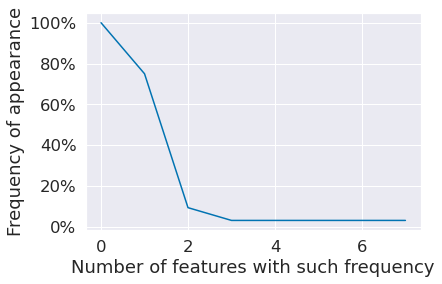

In [30]:
(df_feature_count["percentage"]*100).plot()
ax = plt.gca()
ax.yaxis.set_major_formatter( mtick.PercentFormatter())
plt.ylabel("Frequency of appearance")
plt.xlabel("Number of features with such frequency")
for fmt in ["png", "pdf"]:
    plt.savefig("repetition-freqcurve-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(),fmt=fmt), bbox_inches="tight")

0.125 2 ['mirna_hsa-miR-552-5p', 'clinical_gender_FEMALE']
0.25 2 ['mirna_hsa-miR-552-5p', 'clinical_gender_FEMALE']
0.5 2 ['mirna_hsa-miR-552-5p', 'clinical_gender_FEMALE']
0.75 2 ['mirna_hsa-miR-552-5p', 'clinical_gender_FEMALE']


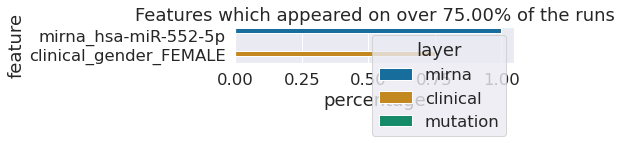

In [31]:
for pct in [0.125, 0.25, 0.5, .75]:
    plt.close()
    most_common_features = df_feature_count[df_feature_count["percentage"]>=pct]["feature"]
    print(pct, len(most_common_features.tolist()), most_common_features.tolist())
    fig = plt.figure(figsize=(5,len(most_common_features.tolist())/3))
    ax = plt.gca()
    sns.barplot(data=df_feature_count.reset_index(), x="percentage", y="feature", hue="layer", ax=ax, order=most_common_features)
    plt.title("Features which appeared on over {:.2%} of the runs".format(pct))
    for fmt in ["png", "pdf"]:
        plt.savefig("repetition-{model}-{date}-{pct}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(), pct=pct, fmt=fmt), bbox_inches="tight")

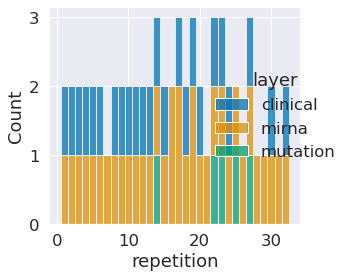

In [32]:
fig = plt.figure(figsize=(4.5,4))
ax = plt.gca()
sns.histplot(data=df_features, stat="count", x="repetition", hue="layer", multiple="stack", discrete=True, ax=ax)
sns.move_legend(
    ax, "center right",
    bbox_to_anchor=(1.2, 0.5),
    frameon=False,
)
for fmt in ["png", "pdf"]:
        plt.savefig("repetition-layer-counts-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(), fmt=fmt), bbox_inches="tight")

In [33]:
LABEL_N_FEAT = "Number of features selected"
LABEL_P_FEAT = "Percentage of layer features selected"
data_df = df_features.groupby(["layer","repetition"])["feature"].count().reset_index().rename(columns={"feature":LABEL_N_FEAT})

all_layers = data_df["layer"].unique()
for rep in data_df["repetition"].unique():
    layers_in_this_repetition = data_df[data_df["repetition"]==rep]["layer"].unique()
    missing_layers = list(set(all_layers) - set(layers_in_this_repetition))
    missing_values_df = pd.DataFrame(
        {
            "layer":missing_layers,
            "repetition":[rep]*len(missing_layers),
            LABEL_N_FEAT:[0]*len(missing_layers)
        }
    )
    data_df = pd.concat([data_df,missing_values_df], ignore_index=True)

data_df[LABEL_P_FEAT] = data_df[LABEL_N_FEAT]
feature_df_to_plot_layer_mapping = {
    "clin": "clinical",
    "cnv": "cnv",
    "gex": "gex",
    "meth": "meth",
    "mirna": "mirna",
    "mut": "mutation",
    "rppa": "rppa",
}
for feature_df_layer in topk_feature_dfs:
    print(feature_df_layer, len(topk_feature_dfs[feature_df_layer].columns))
    data_df_layer = feature_df_to_plot_layer_mapping[feature_df_layer]
    data_df.loc[data_df["layer"]==data_df_layer, LABEL_P_FEAT] = data_df[data_df["layer"]==data_df_layer][LABEL_N_FEAT] / len(topk_feature_dfs[feature_df_layer].columns)



clin 3
cnv 1000
gex 1000
meth 1000
mirna 741
mut 1000
rppa 189


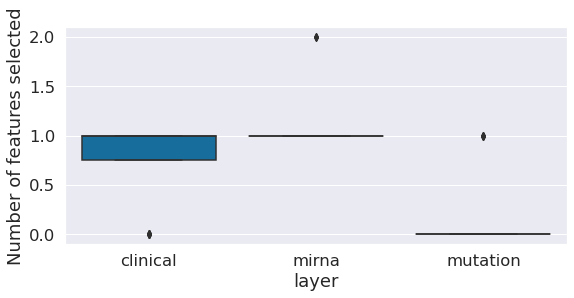

In [34]:
fig = plt.figure(figsize=(9,4))
ax = plt.gca()
sns.boxplot(data=data_df, x="layer", y=LABEL_N_FEAT, ax=ax)
for fmt in ["png", "pdf"]:
        plt.savefig("layer-counts-distr-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(), fmt=fmt), bbox_inches="tight")

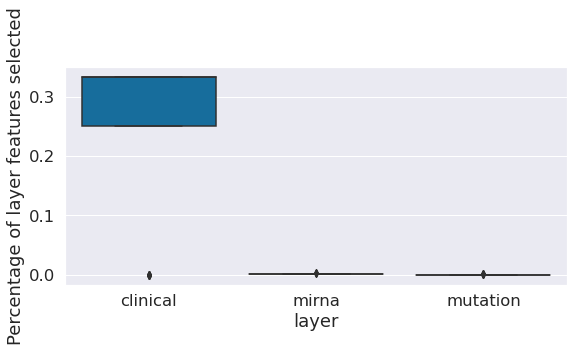

In [35]:
fig = plt.figure(figsize=(9,4))
ax = plt.gca()
sns.boxplot(data=data_df, x="layer", y=LABEL_P_FEAT, ax=ax)
for fmt in ["png", "pdf"]:
        plt.savefig("layer-pct-distr-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(), fmt=fmt), bbox_inches="tight")

In [36]:
data_df.groupby("layer")[[LABEL_N_FEAT, LABEL_P_FEAT]].describe()

Number of features selected                                          \
                               count     mean       std  min   25%  50%  75%   
layer                                                                          
clinical                        32.0  0.75000  0.439941  0.0  0.75  1.0  1.0   
mirna                           32.0  1.09375  0.296145  1.0  1.00  1.0  1.0   
mutation                        32.0  0.15625  0.368902  0.0  0.00  0.0  0.0   

              Percentage of layer features selected                      \
          max                                 count      mean       std   
layer                                                                     
clinical  1.0                                  32.0  0.250000  0.146647   
mirna     2.0                                  32.0  0.001476  0.000400   
mutation  1.0                                  32.0  0.000156  0.000369   

                                                          
              min      25%       50%       75%       max  
layer                                                     
clinical  0.00000  0.25000  0.333333  0.333333  0.333333  
mirna     0.00135  0.00135  0.001350  0.001350  0.002699  
mutation  0.00000  0.00000  0.000000  0.000000  0.001000